

<font face="Lucida Handwriting
" size=6 color='#CDB79E'> Libraries import <font>

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



%matplotlib inline

In [3]:
!pip install xgboost

     --------------------------------------- 89.1/89.1 MB 34.4 MB/s eta 0:00:00


In [3]:
import xgboost
from xgboost import XGBClassifier



<font face="Lucida Handwriting
" size=6 color='#CDB79E'> Buy data EDA and Outliers <font>

In [4]:
df_buy = pd.read_csv('Buy_With_Predicted_Rent.csv')
df_buy.head(10)

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent
0,295000,140,2,3,0,0,0,1,0,1761.992029
1,22500,46,0,2,0,0,1,0,0,387.169896
2,485000,152,3,4,0,0,1,0,0,1831.693994
3,1250000,527,0,10,0,0,0,1,0,5211.002405
4,67000,75,1,2,0,0,1,0,0,766.781801
5,147000,475,4,4,0,0,1,0,0,4649.000758
6,280000,120,4,3,0,0,1,0,0,1631.450533
7,459000,149,8,3,0,0,1,0,0,2428.539470
8,150000,160,1,3,0,0,1,0,0,1545.632665
9,162000,463,0,5,0,0,1,0,0,4066.942106


In [5]:
df_buy.info()
df_buy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10791 entries, 0 to 10790
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           10791 non-null  int64  
 1   Size            10791 non-null  int64  
 2   Bath            10791 non-null  int64  
 3   Bed             10791 non-null  int64  
 4   City_Cascais    10791 non-null  int64  
 5   City_Lisboa     10791 non-null  int64  
 6   City_Other      10791 non-null  int64  
 7   City_Porto      10791 non-null  int64  
 8   City_Sintra     10791 non-null  int64  
 9   predicted_rent  10791 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 843.2 KB


,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent
0,295000,140,2,3,0,0,0,1,0,1761.992029
1,22500,46,0,2,0,0,1,0,0,387.169896
2,485000,152,3,4,0,0,1,0,0,1831.693994
3,1250000,527,0,10,0,0,0,1,0,5211.002405
4,67000,75,1,2,0,0,1,0,0,766.781801



<font face="Lucida Handwriting
" size=5 color='#CDB79E'> Calculate the other monthly expense on the property <font>

Assumptions:
    
-30% downpayment (standard in Portogul)

-4% interest rate (r(monthly rate): 0.003333)

-30 year fixed rate (n(term): 360)

 M = P*r(1+r)^n/((1+r)^n) - 1).

for example
property price - 350,000 euro 
the calculate is - M = (350000 * 0.045 * (1 + 0.045)^360) / ((1 + 0.045)^360 - 1)

In [6]:
# M = P*r(1+r)^n/((1+r)^n) - 1)
#-30% downpayment (standard in Portogul)
#-4% interest rate (r(monthly rate): 0.003333)
#-30 year fixed rate (n(term): 360)
# M = P*r(1+r)^n/((1+r)^n) - 1).
df_buy['Monthly_Mortgage']= ((df_buy['Price'] * 0.003333 * (1 + 0.003333)**360) / ((1 + 0.003333)**360 -1))
# Print the updated dataframe
print(df_buy)

         Price  Size  Bath  Bed  City_Cascais  City_Lisboa  City_Other  \
0       295000   140     2    3             0            0           0   
1        22500    46     0    2             0            0           1   
2       485000   152     3    4             0            0           1   
3      1250000   527     0   10             0            0           0   
4        67000    75     1    2             0            0           1   
...        ...   ...   ...  ...           ...          ...         ...   
10786   135000    22     1    0             0            0           0   
10787   130000    18     1    0             0            0           0   
10788   139900   110     2    3             0            0           1   
10789   799000   720    12    7             0            0           1   
10790   170000   113     2    2             0            0           0   

       City_Porto  City_Sintra  predicted_rent  Monthly_Mortgage  
0               1            0     1761.9920

In [7]:
df_buy['Monthly_Mortgage'] = df_buy['Monthly_Mortgage'].astype('int64')

In [8]:
df_buy.head(10)

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent,Monthly_Mortgage
0,295000,140,2,3,0,0,0,1,0,1761.992029,1408
1,22500,46,0,2,0,0,1,0,0,387.169896,107
2,485000,152,3,4,0,0,1,0,0,1831.693994,2315
3,1250000,527,0,10,0,0,0,1,0,5211.002405,5967
4,67000,75,1,2,0,0,1,0,0,766.781801,319
5,147000,475,4,4,0,0,1,0,0,4649.000758,701
6,280000,120,4,3,0,0,1,0,0,1631.450533,1336
7,459000,149,8,3,0,0,1,0,0,2428.539470,2191
8,150000,160,1,3,0,0,1,0,0,1545.632665,716
9,162000,463,0,5,0,0,1,0,0,4066.942106,773


In [9]:
df1 = df_buy.copy()
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10791 entries, 0 to 10790
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             10791 non-null  int64  
 1   Size              10791 non-null  int64  
 2   Bath              10791 non-null  int64  
 3   Bed               10791 non-null  int64  
 4   City_Cascais      10791 non-null  int64  
 5   City_Lisboa       10791 non-null  int64  
 6   City_Other        10791 non-null  int64  
 7   City_Porto        10791 non-null  int64  
 8   City_Sintra       10791 non-null  int64  
 9   predicted_rent    10791 non-null  float64
 10  Monthly_Mortgage  10791 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 927.5 KB


,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent,Monthly_Mortgage
0,295000,140,2,3,0,0,0,1,0,1761.992029,1408
1,22500,46,0,2,0,0,1,0,0,387.169896,107
2,485000,152,3,4,0,0,1,0,0,1831.693994,2315
3,1250000,527,0,10,0,0,0,1,0,5211.002405,5967
4,67000,75,1,2,0,0,1,0,0,766.781801,319



<font face="Lucida Handwriting
" size=5 color='#CDB79E'> Calculate the other monthly expense on the property <font>

-1% property tax

-0.5% property insurance

-0.5% of purchase value for yearly expense

the formula is Total monthly expense = Property tax + Property insurance + Yearly expense/12

->  P*0.01 + P*0.005 + P*0.005/12

and it's also ok 
to calculate with Price * 0.00217 instead

In [10]:
df1['Monthly_Other'] = (df1['Price'] * 0.00217)
df1.head()

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent,Monthly_Mortgage,Monthly_Other
0,295000,140,2,3,0,0,0,1,0,1761.992029,1408,640.150
1,22500,46,0,2,0,0,1,0,0,387.169896,107,48.825
2,485000,152,3,4,0,0,1,0,0,1831.693994,2315,1052.450
3,1250000,527,0,10,0,0,0,1,0,5211.002405,5967,2712.500
4,67000,75,1,2,0,0,1,0,0,766.781801,319,145.390


In [11]:
# calculate and add a new column that shows the profit that the property owner stay in his 
# bank account after all month
# this is the predicted rent of the property
# after all the expenses such as mortgage and other like apartment taxes
# maintenance and insurance 
df1['Monthly_Profit'] = (df1['predicted_rent'] - df1['Monthly_Mortgage'] - df1['Monthly_Other'])

In [12]:
df1

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent,Monthly_Mortgage,Monthly_Other,Monthly_Profit
0,295000,140,2,3,0,0,0,1,0,1761.992029,1408,640.150,-286.157971
1,22500,46,0,2,0,0,1,0,0,387.169896,107,48.825,231.344896
2,485000,152,3,4,0,0,1,0,0,1831.693994,2315,1052.450,-1535.756006
3,1250000,527,0,10,0,0,0,1,0,5211.002405,5967,2712.500,-3468.497595
4,67000,75,1,2,0,0,1,0,0,766.781801,319,145.390,302.391801
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10786,135000,22,1,0,0,0,0,0,0,976.560974,644,292.950,39.610974
10787,130000,18,1,0,0,0,0,0,0,943.395058,620,282.100,41.295058
10788,139900,110,2,3,0,0,1,0,0,1270.217720,667,303.583,299.634720
10789,799000,720,12,7,0,0,1,0,0,8015.910647,3814,1733.830,2468.080647


In [13]:
# stays only with the end profit column
df2 = df1.copy()
df2 = df2.drop(columns = ['predicted_rent', 'Monthly_Mortgage', 'Monthly_Other'])
df2.head()

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,Monthly_Profit
0,295000,140,2,3,0,0,0,1,0,-286.157971
1,22500,46,0,2,0,0,1,0,0,231.344896
2,485000,152,3,4,0,0,1,0,0,-1535.756006
3,1250000,527,0,10,0,0,0,1,0,-3468.497595
4,67000,75,1,2,0,0,1,0,0,302.391801


In [14]:
df2.describe()

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,Monthly_Profit
count,1.079100e+04,10791.000000,10791.000000,10791.000000,10791.000000,10791.000000,10791.000000,10791.000000,10791.000000,1.079100e+04
mean,4.437273e+05,220.725975,2.060977,2.783245,0.056529,0.189788,0.563154,0.063571,0.071356,-6.829360e+02
std,5.533448e+05,2195.152885,1.524586,1.445328,0.230950,0.392151,0.496018,0.243999,0.257430,1.845231e+04
min,3.500000e+03,7.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.778924e+04
25%,1.800000e+05,82.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.572505e+03
50%,2.850000e+05,118.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-5.244441e+02
75%,5.000000e+05,179.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.187871e+01
max,1.250000e+07,127500.000000,21.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.056347e+06


In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10791 entries, 0 to 10790
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           10791 non-null  int64  
 1   Size            10791 non-null  int64  
 2   Bath            10791 non-null  int64  
 3   Bed             10791 non-null  int64  
 4   City_Cascais    10791 non-null  int64  
 5   City_Lisboa     10791 non-null  int64  
 6   City_Other      10791 non-null  int64  
 7   City_Porto      10791 non-null  int64  
 8   City_Sintra     10791 non-null  int64  
 9   Monthly_Profit  10791 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 843.2 KB



<font face="Lucida Handwriting
" size=5 color='#CDB79E'> outliers treatment and cleanning the unneccessery data <font>


In [16]:
# bed and bath being zero
print(df2['Bath'].value_counts()[0])
print(df2['Bed'].value_counts()[0])



1144
292


In [17]:
# drop rows with bath <0 and bed = 0
df2.drop(df2[(df2.Bath ==0) | (df2.Bed ==0)].index, inplace=True)
df2.drop(df2[df2.Bath < 0].index, inplace=True)
df2.describe()



,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,Monthly_Profit
count,9.474000e+03,9474.000000,9474.000000,9474.000000,9474.000000,9474.000000,9474.000000,9474.000000,9474.000000,9474.000000
mean,4.667898e+05,187.450391,2.328583,2.851805,0.062170,0.202027,0.551087,0.061220,0.077053,-1072.790066
std,5.649275e+05,1384.706424,1.428847,1.344727,0.241477,0.401533,0.497410,0.239746,0.266690,11862.366344
min,1.000000e+04,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-77789.236505
25%,1.939925e+05,84.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1729.056045
50%,2.999000e+05,119.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-584.818428
75%,5.400000e+05,179.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-31.114903
max,1.250000e+07,103890.000000,21.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,860193.535809


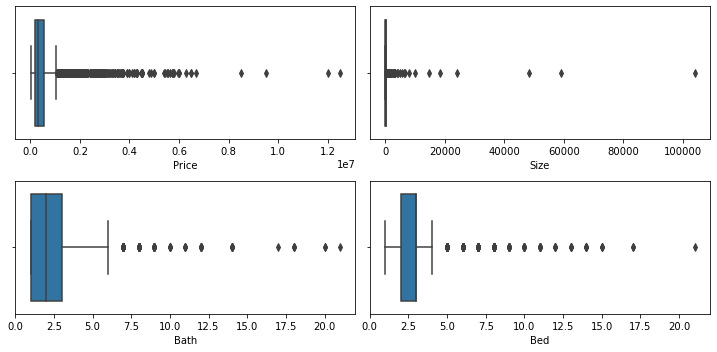

In [18]:
# Outlier Analysis
fig, axs = plt.subplots(2,2, figsize = (10,5))
plt1 = sns.boxplot(df2['Price'], ax = axs[0,0])
plt2 = sns.boxplot(df2['Size'], ax = axs[0,1])
plt1 = sns.boxplot(df2['Bath'], ax = axs[1,0])
plt2 = sns.boxplot(df2['Bed'], ax = axs[1,1])

plt.tight_layout()



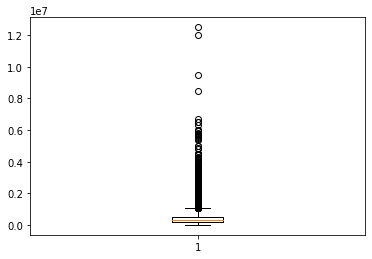

In [19]:
# outlier treatment for Price
plt.boxplot(df2.Price)
Q1 = df2.Price.quantile(0.25)
Q3 = df2.Price.quantile(0.75)
IQR = Q3 - Q1
df2 = df2[(df2.Price >= Q1 - 1.5*IQR) & (df2.Price <= Q3 + 1.5*IQR)]



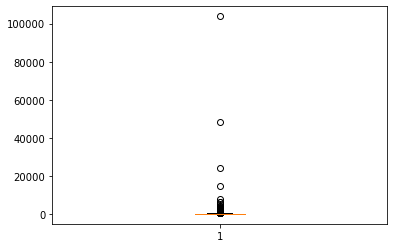

In [20]:
# outlier treatment for Size
plt.boxplot(df2.Size)
Q1 = df2.Size.quantile(0.25)
Q3 = df2.Size.quantile(0.75)
IQR = Q3 - Q1
df2 = df2[(df2.Size >= Q1 - 1.5*IQR) & (df2.Size <= Q3 + 1.5*IQR)]



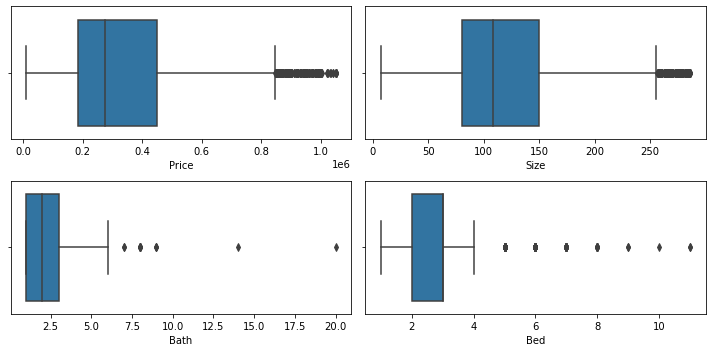

In [21]:
# Outlier Analysis
fig, axs = plt.subplots(2,2, figsize = (10,5))
plt1 = sns.boxplot(df2['Price'], ax = axs[0,0])
plt2 = sns.boxplot(df2['Size'], ax = axs[0,1])
plt1 = sns.boxplot(df2['Bath'], ax = axs[1,0])
plt2 = sns.boxplot(df2['Bed'], ax = axs[1,1])

plt.tight_layout()



In [22]:
df2.describe()

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,Monthly_Profit
count,8.230000e+03,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000
mean,3.414544e+05,120.189429,2.043013,2.624180,0.045808,0.198542,0.566586,0.062697,0.078493,-829.577018
std,2.130198e+05,54.689708,1.038028,1.058881,0.209081,0.398927,0.495577,0.242433,0.268963,1226.654923
min,1.000000e+04,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5646.110881
25%,1.850000e+05,80.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1358.662886
50%,2.750000e+05,108.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-534.224251
75%,4.490000e+05,150.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-53.774573
max,1.050000e+06,286.000000,20.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2400.282925


In [23]:
df2.drop(df2[(df2.Size ==1)].index, inplace=True)
df2.describe()



,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,Monthly_Profit
count,8.230000e+03,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000
mean,3.414544e+05,120.189429,2.043013,2.624180,0.045808,0.198542,0.566586,0.062697,0.078493,-829.577018
std,2.130198e+05,54.689708,1.038028,1.058881,0.209081,0.398927,0.495577,0.242433,0.268963,1226.654923
min,1.000000e+04,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5646.110881
25%,1.850000e+05,80.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1358.662886
50%,2.750000e+05,108.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-534.224251
75%,4.490000e+05,150.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-53.774573
max,1.050000e+06,286.000000,20.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2400.282925


<AxesSubplot:xlabel='Bath', ylabel='Bed'>

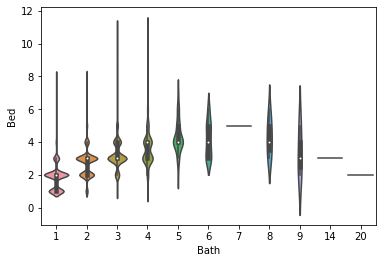

In [28]:
sns.violinplot(data=df2, x="Bath", y="Bed")

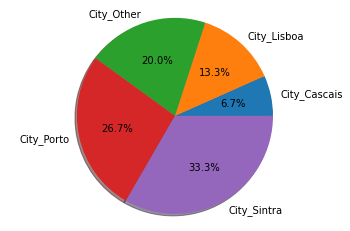

In [29]:
# https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py

data = [1,2,3,4,5]
labels = ['City_Cascais','City_Lisboa','City_Other','City_Porto','City_Sintra']
plt.pie(data,labels=labels, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()

In [30]:
# we want to predict the price , we need the table similar to the rent table we treated
# in Ml we need to delete the target column
dataf = df2.copy()
dataf = dataf.drop(columns = ['Price'])



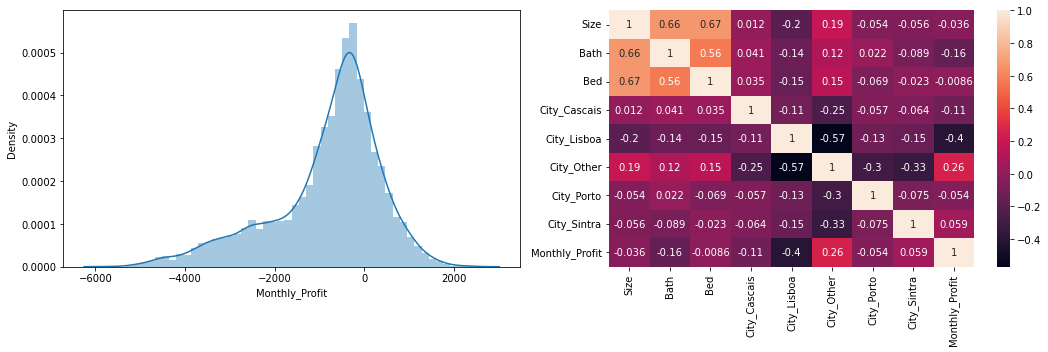

In [31]:
# histogram and heat map
corr = dataf.corr()
fig, axs = plt.subplots(1,2, figsize=[15,5])
sns.distplot(dataf['Monthly_Profit'], ax=axs[0])
sns.heatmap(corr, ax=axs[1], annot=True)
fig.tight_layout()



In [32]:
dataf['good_prop'] = np.where(dataf['Monthly_Profit'] > -400, 1, 0)  # good if monthly expense is less than 400
dataf = dataf.drop(columns = ['Monthly_Profit'])
dataf.head()



,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,good_prop
0,140,2,3,0,0,0,1,0,1
2,152,3,4,0,0,1,0,0,0
4,75,1,2,0,0,1,0,0,1
6,120,4,3,0,0,1,0,0,1
7,149,8,3,0,0,1,0,0,0


In [33]:
dataf.describe()

,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,good_prop
count,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000
mean,120.189429,2.043013,2.624180,0.045808,0.198542,0.566586,0.062697,0.078493,0.431106
std,54.689708,1.038028,1.058881,0.209081,0.398927,0.495577,0.242433,0.268963,0.495261
min,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,108.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,150.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,286.000000,20.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
dataf.to_csv(r'Buy_Before_MachineLearning.csv', index = False, header=True)

In [35]:
ML = pd.read_csv('Buy_Before_MachineLearning.csv')

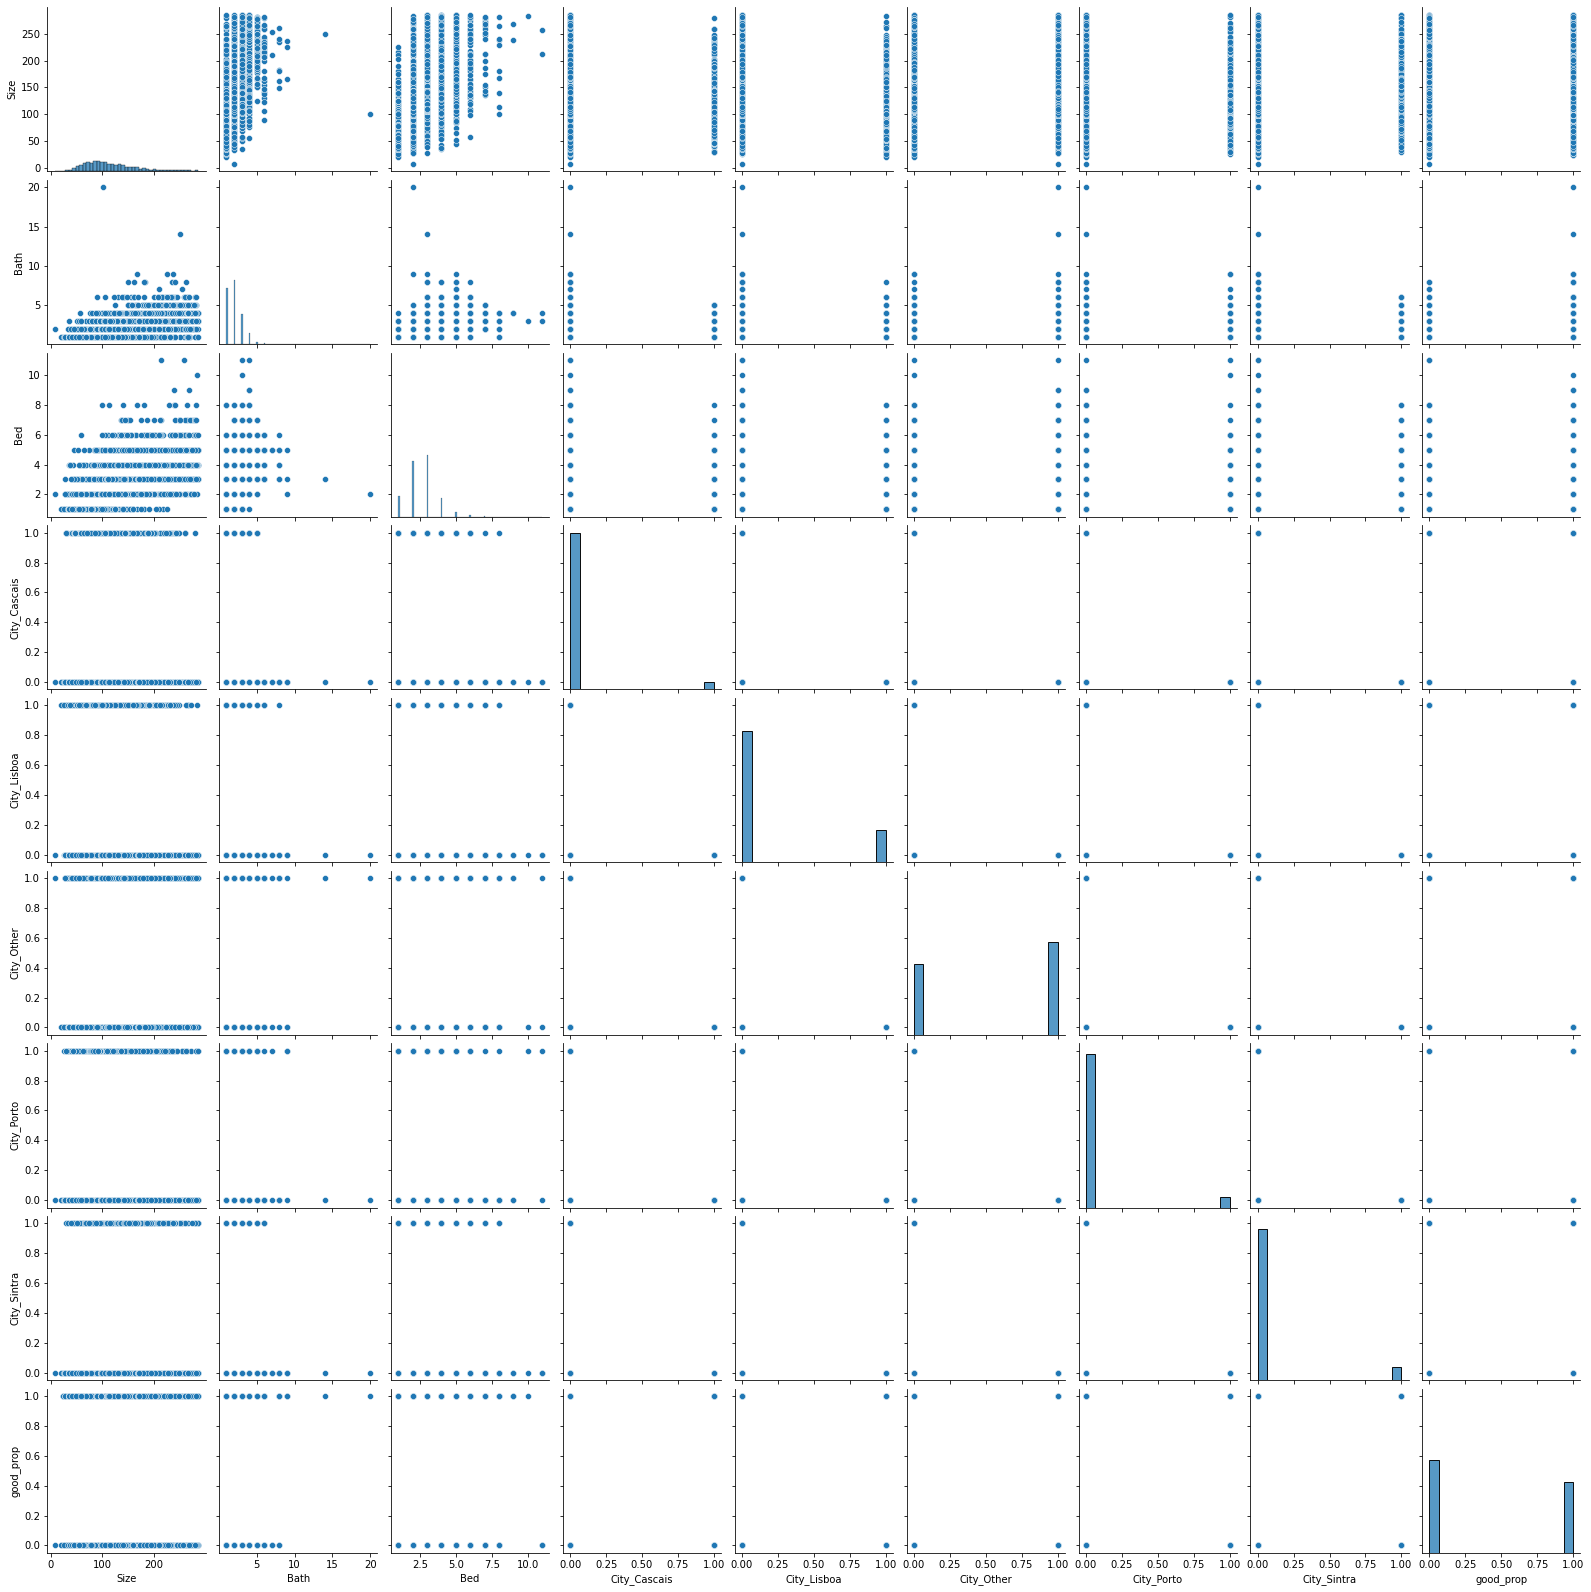

In [36]:
sns.pairplot(ML)
plt.show()




<font face="Lucida Handwriting
" size=5 color='#CDB79E'> Good Vs Bad Property <font>


Text(0, 0.5, 'Count')

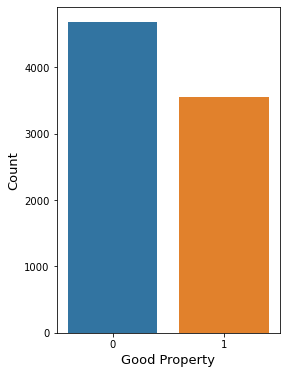

In [37]:
plt.figure(figsize=(4,6))

sns.countplot(x='good_prop', data=ML)
plt.xlabel('Good Property', fontsize=13)
plt.ylabel('Count', fontsize=13)



In [38]:
# check out of 100% how many percent
# It is a good property and what percentage is a bad property

print('not good: {}%'.format(round((ML['good_prop'].value_counts()[0] / ML.shape[0]), 2)*100))
print('good: {}%'.format(round((ML['good_prop'].value_counts()[1] / ML.shape[0]), 2)*100))

not good: 56.99999999999999%
good: 43.0%



<font face="Lucida Handwriting
" size=5 color='#CDB79E'> Classification model <font>


In [39]:
# feature = X
# target = Y
# X created by dropping the 'good_prop' from the original data set
# The target vector y is then assigned to the good_prop column from the original dataset
X = ML.drop(columns = ['good_prop'])
predictors = X.columns
y = ML['good_prop']


<font face="Lucida Handwriting
" size=5 color='#CDB79E'> Logistic Regression <font>


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

z = StandardScaler()
z.fit(X_train[['Size']])  # size is the only continuous var

X_train['Size'] = z.transform(X_train[['Size']]) # transform - to subtract the mean and divide by the standard deviation in 
X_test['Size'] = z.transform(X_test[['Size']]) # order to get the standardized values

In [41]:
lr = LogisticRegression()

In [42]:
# taking in the feature matrix X_train and target vector y_train
# the traget of this method is to calculate the coefficients of the linear regression model 
# using the training data and store them in the lr object.

lr.fit(X_train, y_train) 

LogisticRegression()

In [43]:
# make predictions on the test data
lr_pred = lr.predict(X_test)

In [44]:
accuracy_score(y_test, lr_pred)

0.6877278250303767

In [45]:
# calculate the precision, recall, and f-score of the linear regression model. 
# set to macro which calculates the metrics for each label and then takes the average of them .

precision, recall, fscore, support = score(y_test, lr_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')



Precision : 0.6895781637717122
Recall    : 0.6952276073544981
F-score   : 0.6859454924757047


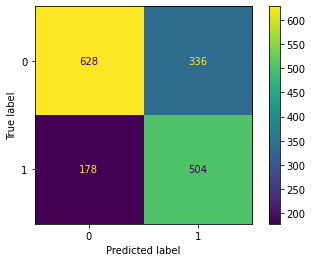

In [46]:
plot_confusion_matrix(lr, X_test, y_test)



In [47]:
# LR Coef interpretation
coef = pd.DataFrame({"Coefs": lr.coef_[0],  #[0] needed for Logistic Regression,lr.coef_[0] method is used to get the coefficients from the lr model
                    "Names": predictors})  # the predictors variable is used to get the feature names
coef = coef.append({"Coefs": lr.intercept_[0],  
                    "Names": "intercept"}, ignore_index = True) # check that the index of the dataframe is reset when the intercept is appended


In [48]:
# adding odds
# np.exp() calculates the exponential of each element
coef['Odds Coefs'] = np.exp(coef['Coefs'])
coef # print the data frame we created above



,Coefs,Names,Odds Coefs
0,0.115042,Size,1.121921
1,-0.441402,Bath,0.643134
2,0.157835,Bed,1.170973
3,-3.051520,City_Cascais,0.047287
4,-3.979764,City_Lisboa,0.018690
5,-1.853800,City_Other,0.156641
6,-3.305936,City_Porto,0.036665
7,-1.796576,City_Sintra,0.165866
8,2.462683,intercept,11.736263


In [49]:
# predict_proba() method will use the coefficients of the linear regression model
# https://stackoverflow.com/questions/57226375/sklearn-logistic-regression-predict-proba-returning-0-or-1
ypred_prob = lr.predict_proba(X)

In [50]:
# the second column contains the probability of each data point belonging to the positive class
ypred_prob1 = ypred_prob[:, 1]

In [51]:
# Data points with a probability of belonging to the positive class greater than 0.5 

# are assigned to the positive class and data points with a probability less than 0.5 are assigned to the negative class

# Setting the threshold to 0.5 is arbitrary and can be adjusted depending on the desired accuracy of the model

thresh = 0.5

# any values that are greater than 0.5 are set to 1 and any values that are less than 0.5 are set to 0

ypred_prob_thresh = (ypred_prob1 > thresh) * 1 

accuracy_score(y, ypred_prob_thresh) # This will return the accuracy of the model using the threshold of 0.5.



0.43110571081409477

In [52]:
# regularization

# we used it to improve the performance on unseen data

# it could help to avoid overfitting

lr_reg = LogisticRegression(penalty = 'none') # 'none' which mean there is no regularization used
lr_reg.fit(X_train, y_train)



LogisticRegression(penalty='none')

In [53]:
# using the LogisticRegression to make predictions on the test data, and the accuracy_score

# function to evaluate the performance of the model

lr_reg_pred = lr_reg.predict(X_test)
accuracy_score(y_test, lr_reg_pred)



0.6877278250303767


<font face="Lucida Handwriting
" size=5 color='#CDB79E'>  Decision Tree <font>


In [54]:
# Repeat the process again

# Only this time with a decision tree

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)



DecisionTreeClassifier()

In [55]:
tree_pred = tree.predict(X_test)

accuracy_score(y_test, tree_pred)



0.6865127582017011

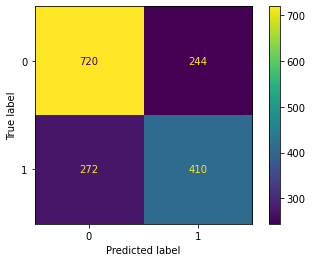

In [56]:
plot_confusion_matrix(tree, X_test, y_test)

In [57]:
# using the get_depth() method to get the depth of the decision tree model.

# to determine the number of layers in the model

tree.get_depth()

29

In [58]:
# using the get_n_leaves() method to get the number of leaves in the decision tree model.

# number of decisions being made by the model

tree.get_n_leaves()

1527

In [59]:
# reducing tree depth

# used DT documentation - https://scikit-learn.org/0.15/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# creating a decision tree model with a maximum depth of 15 and then fitting it to the training data.

# The model is then used to make predictions on the test data and the accuracy of the model is calculated using the accuracy_score() function.

tree15 = DecisionTreeClassifier(max_depth =15)
tree15.fit(X_train, y_train)
tree15_pred = tree.predict(X_test)
accuracy_score(y_test, tree15_pred)



0.6865127582017011

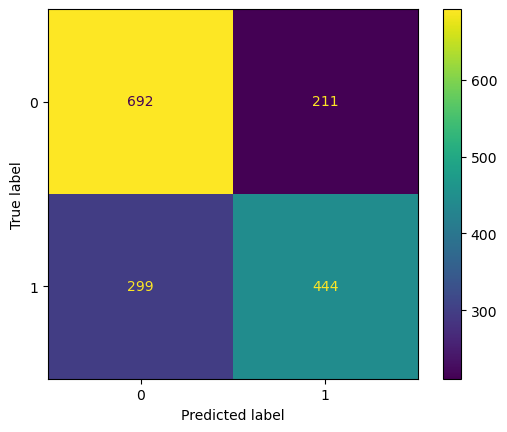

In [85]:
plot_confusion_matrix(tree15, X_test, y_test)

In [60]:
# can be used to determine which features are the most important in the model and which can be removed if necessary.

# https://stackoverflow.com/questions/49170296/scikit-learn-feature-importance-calculation-in-decision-trees

tree15.feature_importances_

array([0.42085305, 0.11449772, 0.09484537, 0.03856403, 0.21064054,
       0.02537112, 0.06308825, 0.03213992])


<font face="Lucida Handwriting
" size=5 color='#CDB79E'>  Model Comparison <font>

Testing 6 different algorithms:

Logistic Regression (LR)

K-Nearest Neighbors (KNN)

Random Forest (RF)

Decision Trees (DT)

Gaussian Naive Bayes (NB)

Support Vector Machines (SVM)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

z = StandardScaler() # common scale (between 0 and 1).
z.fit(X_train[['Size']])  # size is the only continuous var

X_train['Size'] = z.transform(X_train[['Size']])
X_test['Size'] = z.transform(X_test[['Size']])

In [62]:
# Algorithms
models = []
# solver and multi_class are specific to the LogisticRegression class and are not needed for the other models in the list.
# use https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html to understand the solver
# and the multi_class roles
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr'))) 
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))
# eval_metric parameter is set to 'logloss' which is the metric that will be used to evaluate the performance of the model
models.append(('XGBoost', XGBClassifier(eval_metric='logloss')))

# Evaluate each model
results = []
names = []
for name, model in models:
    # set to 1 which ensures that the same split of the data is used each time
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    # using 10-fold cross validation and the accuracy metric
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy') 
    results.append(cv_results)
    names.append(name)
    
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))



LR: 0.677552 (0.015389)
KNN: 0.683173 (0.012226)
RF: 0.680747 (0.016745)
DT: 0.670265 (0.019072)
NB: 0.645963 (0.015128)
SVM: 0.682868 (0.016269)
XGBoost: 0.685756 (0.020575)


<font face="Lucida Handwriting
" size=6 color='#CDB79E'>  Results <font>


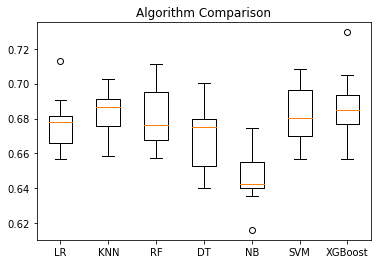

In [63]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()



In [64]:
# Create list of model and accuracy dicts
summaryList = []

# List for storing scores
scores = []



In [65]:
# function to evaluate model and store scores
# find to every moudle the mean and his probabilities
# find the accuracy score and round it

def model_eval(algorithm, name, X_train, y_train):

    class_model = algorithm

    # Calculate accuracy of train
    acc = cross_val_score(class_model, X_train, y_train).mean() # cross_val_score
                                                                # used to evaluate the performance of a machine learning 
                                                                # model using k-fold cross validation.

    class_model.fit(X_train, y_train)

    # Get predictions and probabilities
    y_preds = class_model.predict(X_test)
    y_score = class_model.predict_proba(X_test)

    # Calculate accuracy of test
    acc_test = round(accuracy_score(y_test, y_preds), 3)

    # Get precision, recall, f1-score
    precision, recall, fscore, support = score(y_test, y_preds, average='macro')

    # Add model and accuracy dict to list
    # to create the data frame
    # and present all the result
    # one side by one
    
    summaryList.append(dict([
        ('Model', name),
        ('Train Accuracy', round(acc, 3)),
        ('Test Accuracy', acc_test),
        ('Precision', round(precision, 3)),
        ('Recall', round(recall, 3)),
        ('F1', round(fscore, 3))
         ]))

    # Add y_score to list
    scores.append(y_score)



In [66]:
model_eval(LogisticRegression(), 'LR', X_train, y_train)
model_eval(KNeighborsClassifier(), 'KNN', X_train, y_train)
model_eval(RandomForestClassifier(), 'Random Forest', X_train, y_train)
model_eval(DecisionTreeClassifier(), 'Dec Tree', X_train, y_train)
model_eval(GaussianNB(), 'Gaussian NB', X_train, y_train)
model_eval(SVC(probability=True), 'SVM', X_train, y_train)
model_eval(XGBClassifier(eval_metric='auc'), 'XGBoost', X_train, y_train)

In [67]:
model_summary = pd.DataFrame(data=summaryList)
model_summary = model_summary[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_summary.drop_duplicates(inplace=True)
model_summary



,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,LR,0.678,0.683,0.682,0.684,0.682
1,KNN,0.688,0.671,0.666,0.665,0.665
2,Random Forest,0.675,0.683,0.678,0.678,0.678
3,Dec Tree,0.673,0.665,0.659,0.653,0.654
4,Gaussian NB,0.646,0.651,0.713,0.679,0.644
5,SVM,0.685,0.697,0.697,0.700,0.696
6,XGBoost,0.684,0.688,0.683,0.681,0.682


In [68]:
# We chose to present the results we received 
# by roc curve Because it's a very clean graph
# And very clear to understand
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python, & GPT 
# https://www.statology.org/plot-roc-curve-python/
# https://stackoverflow.com/questions/70278059/plotting-the-roc-curve-for-a-multiclass-problem
# https://stackoverflow.com/questions/72931472/how-to-plot-roc-curves-based-on-mean-and-standard-deviation-in-python


def plot_roc_curves():
    plt.figure(figsize=(10,6))
    lw = 2 # line width
    
    # fpr = false positive rate
    # tpr = true positive rate
    
    # Logistic Regression
    
    # The y_test parameter is the of the true labels for the test set and the scores[0][:,1] 
    # The pos_label parameter is set to 1 which specifies the label that should be used as the positive class.
    # parameters to calculate the false positive rate (fpr),
    # true positive rate (tpr), and thresholds which can then be used to plot the ROC curve.
    
    fpr, tpr, thresholds = roc_curve(y_test, scores[0][:,1], pos_label=1)
    auc_lr = roc_auc_score(y_test, scores[0][:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='LR, AUC=%.3f' % auc_lr) #  AUC is the area under the curve for the model
                                                   # %.3f' three decimal places , to displayed accurately 
                                                   # when the line is plotted.
                                                   # this will produce in the lower right of the plot
        
    # KNN
    fpr, tpr, thresholds = roc_curve(y_test, scores[1][:,1], pos_label=1)
    auc_knn = roc_auc_score(y_test, scores[1][:,1])
    plt.plot(fpr, tpr, color='y',
             lw=lw, label='KNN, AUC=%.3f' % auc_knn)
    
    # Random Forest
    fpr, tpr, thresholds = roc_curve(y_test, scores[2][:,1], pos_label=1)
    auc_rf = roc_auc_score(y_test, scores[2][:,1])
    plt.plot(fpr, tpr, color='b',
             lw=lw, label='Random Forest, AUC=%.3f' % auc_rf)
    
    # Decision Tree
    fpr, tpr, thresholds = roc_curve(y_test, scores[3][:,1], pos_label=1)
    auc_dt = roc_auc_score(y_test, scores[3][:,1])
    plt.plot(fpr, tpr, color='g',
             lw=lw, label='Decision Tree, AUC=%.3f' % auc_dt)
    
    # Gaussian NB
    fpr, tpr, thresholds = roc_curve(y_test, scores[4][:,1], pos_label=1)
    auc_nb = roc_auc_score(y_test, scores[4][:,1])
    plt.plot(fpr, tpr, color='c',
             lw=lw, label='Gaussian NB, AUC=%.3f' % auc_nb)
    
    # SVM
    fpr, tpr, thresholds = roc_curve(y_test, scores[5][:,1], pos_label=1)
    auc_svm = roc_auc_score(y_test, scores[5][:,1])
    plt.plot(fpr, tpr, color='m',
             lw=lw, label='SVM, AUC=%.3f' % auc_svm)    
    
    # XGBoost
    fpr, tpr, thresholds = roc_curve(y_test, scores[6][:,1], pos_label=1)
    auc_xgb = roc_auc_score(y_test, scores[6][:,1])
    plt.plot(fpr, tpr, color='lime',
             lw=lw, label='XGBoost, AUC=%.3f' % auc_xgb) 
    
    
    # Formatting
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0]) # xlim and ylim parameters used to set the limits of the x and y axes
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12) # The xlabel and ylabel parameters are 
    plt.ylabel('True Positive Rate', fontsize=12)  # used to set the labels of the x and y axes.
    plt.title('ROC Curve', fontsize=12) # set the title of the plot
    plt.legend(loc="lower right") # specify the location of the legend 
    plt.show()



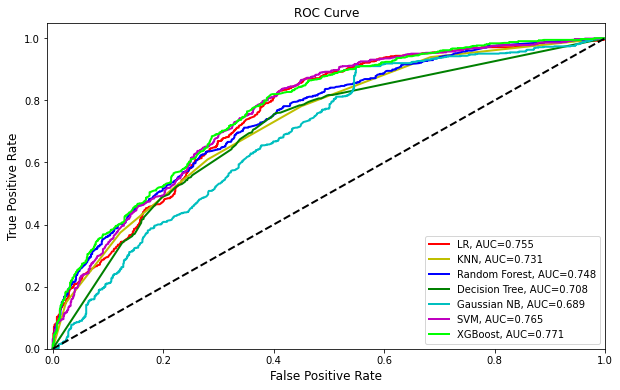

In [69]:
plot_roc_curves()